In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize
import emcee

z = 0.04573
cont = np.array([5.86498523e-11, -1.32890197e+00, 1.12131515e-16])
sub = 0

#### Functions

In [2]:
def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    return diskout,narrowmodel

def model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    model = np.sum((diskout,narrowmodel),axis=0)
    return model

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 

        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0

class logprob_circ_fixeddoublet_freeamplitudes_Halpha(object):
    def __init__(self, x, y, yerr, lines, fixed, fitted, mins, maxes):   
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout = plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted) 
        return diskout,narrowout

def loglikelihood_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    model = np.sum((diskout,narrowmodel),axis=0)
    sigma2 = yerr**2  
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#### Spec

In [3]:
fn = 'spec.txt'
wl, flux = np.loadtxt(fn, unpack=True)
flux -= power_law(wl, *cont) - sub
flux *= 1e17

olambda = 6563
wavemin = 6100
wavemax = 7000
wave = wl/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]

In [4]:
# Integration, units, normalization
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]

# Circular disk size and emission properties
q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-3   # optical depth normalization (0=no wind)
eta = 1. #optical depth power-law index
anglam = 2.1 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
amp = 1e-12 #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 95 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 0 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 0 #outer spiral arm radius radius (GM/c^2, 0=XI2)

#Narrow lines
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components

In [5]:
angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 10000
broadmin, broadmax = 0, 2000
ampmin, ampmax = -1e-12, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -720, 360*3
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 1, 30
NIIbfluxmin, NIIbfluxmax = 0.0, 8
SIIbfluxmin, SIIbfluxmax = 0.0, 300
diskfluxmin, diskfluxmax = 1, 500

diskmins = [
xi1min,xi2min,broadmin,angimin,narrowfracmin,narrowwidthmin,narrowwidth2min,anglammin,t0min,etamin,Halphafluxmin,NIIbfluxmin,diskfluxmin]
diskmax = [
xi1max,xi2max,broadmax,angimax,narrowfracmax,narrowwidthmax,narrowwidth2max,anglammax,t0max,etamax,Halphafluxmax,NIIbfluxmax,diskfluxmax]

In [6]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 2.3
NIIbflux = 0.3
diskflux = 9.4
SIIbflux = 0

In [7]:
angi = 26 #disk inclination angle (degrees)
xi1 = 430 #inner disk radius (GM/c^2)
xi2 = 880 #outer disk radius (multiple of xi1)
broad = 1599 #broadening parameter (km/s)

fitted_labels = ['xi1','xi2','broad','angi','narrowfrac','narrowwidth','narrowwidth2','anglam','t0','eta','Halphaflux','NIIbflux','diskflux']
initial = [xi1,xi2,broad,angi,narrowfrac,narrowwidth,narrowwidth2,anglam,t0,eta,Halphaflux,NIIbflux,diskflux]
fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','amp','narms','aobs','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix','SIIbflux']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,amp,narms,aobs,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix,SIIbflux]
fixed = dict(zip(fixed_labels,fixed_values))

In [8]:
for i,x in enumerate(initial):
    print(diskmins[i],x,diskmax[i])

50 430 10000
100 880 10000
0 1599 2000
-360 26 360
0.1 0.2 5.0
0.1 1.7 15.0
0.1 0.9 12.0
2.0 2.1 40
1e-10 0.001 100.0
-1.5 1.0 1.5
1 2.3 30
0.0 0.3 8
1 9.4 500


In [9]:
modelguess = model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(initial, wl, flux, fluxerr, lines, fixed, fitted)
disk,narrowlines= plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(initial, wl, flux, fluxerr, lines, fixed, fitted)

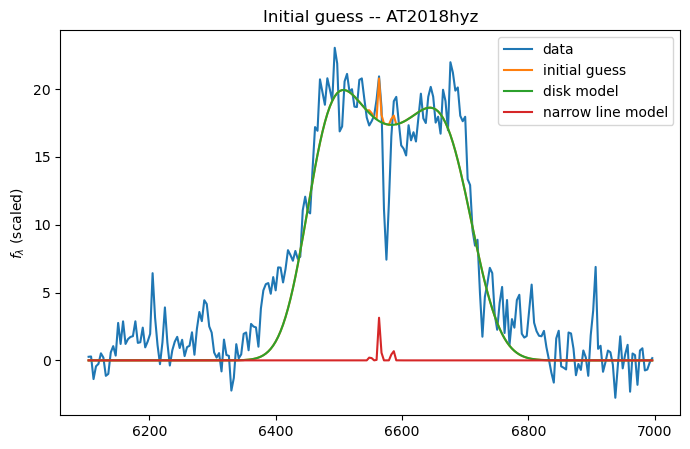

In [10]:
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelguess,label='initial guess')
plt.plot(wl/(1+fixed['z']),disk,label='disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='narrow line model')
plt.ylabel(r'f$_\lambda$ ' + ' (10$^{17}\cdot$erg/s/cm$^2$/Hz)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('Initial guess -- AT2018hyz')
plt.legend()
plt.show()

In [11]:
lp = logprob_circ_fixeddoublet_freeamplitudes_Halpha(wl, flux, fluxerr, lines, fixed, fitted, diskmins, diskmax)

In [12]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)

print('Best-fit parameter values:', soln.x)

Best-fit parameter values: [5.82503632e+02 7.67728417e+02 1.95355334e+03 2.75125610e+01
 5.55727560e-01 2.25738040e+00 8.54384593e-01 2.09147050e+00
 1.06470056e-10 1.48589507e+00 3.49230217e+00 3.64309355e-01
 1.54103526e+01]


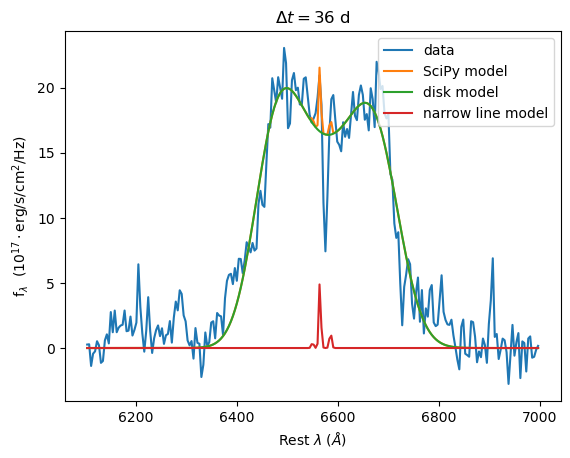

In [16]:
disk,narrowlines = lp.plot(soln.x)
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelfit,label='SciPy model')
plt.plot(wl/(1+fixed['z']),disk,label='disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='narrow line model')
plt.xlabel('Rest $\lambda$ ($\AA$)'); plt.ylabel(r'f$_\lambda$ ' + r' ($10^{17}\cdot$erg/s/cm$^2$/Hz)')
plt.title(r'$\Delta t=36$ d'); plt.legend(loc=1)
plt.savefig('SciPy-E1.png')
plt.show()